# COVID-19-Growth By State (US)
> Average daily new confirmed cases vs. confirmed cases, per US state, ala minutephysics' https://youtu.be/54XLXg4fYsc

- author: Daniel Cox
- categories: [growth, US, states]
- image: images/covid-growth-states.png
- permalink: /growth-us-states/

In [1]:
#hide
%matplotlib inline
import math
import requests
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime

import seaborn as sbn

states_url = "https://covidtracking.com/api/states/daily"
us_url = "https://covidtracking.com/api/us/daily"
case_threshold = 100 # TODO for my visualization, I don't want to drop states below 100

r = requests.get(states_url)
states_df = pd.DataFrame(r.json())
states_df['date'] = pd.to_datetime(states_df.date, format="%Y%m%d")
states_df = states_df[['date', 'state', 'positive', 'death']].sort_values('date')
cols = {}
for state in states_df.state.unique():
    cases = states_df[(states_df.state == state) & (states_df.positive > case_threshold)]
    cases = cases.reset_index().positive.reset_index(drop=True)
    if len(cases) > 1:
        cols[state] = cases
        
r = requests.get(us_url)
us_df = pd.DataFrame(r.json())
us_df['date'] = pd.to_datetime(us_df.date, format="%Y%m%d")
us_df = us_df[['date', 'positive', 'death']].sort_values('date')
us_df['state'] = 'US'
cols['US'] = us_df.positive.reset_index(drop=True)

us_df['state'] = 'US'
# states_df = states_df.append(us_df, ignore_index=True)
df = states_df.reset_index()
# df

In [2]:
df = (df.assign(daily_new=df.groupby('state', as_index=False)[['positive']]
                            .diff().fillna(0)
                            .reset_index(0, drop=True)))
# df[df['state']=='NY']

In [3]:
df = (df.assign(avg_daily_new=df.groupby('state', as_index=False)[['daily_new']]
                                .rolling(7).mean()
                                .reset_index(0, drop=True)))
# df[df.state=='NY']

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


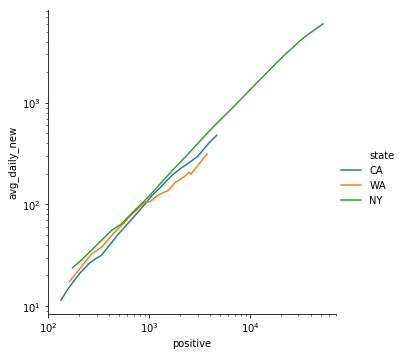

In [4]:
plot = sbn.relplot(x='positive', y='avg_daily_new', kind='line', hue='state', data=df[df['state'].isin(['NY', 'WA', 'CA'])])
plot.set(xscale="log", yscale="log")

In [5]:
#hide
df

,index,date,state,positive,death,daily_new,avg_daily_new
0,1260,2020-03-04,WI,1.0,NaN,0.0,NaN
1,1247,2020-03-04,AZ,2.0,NaN,0.0,NaN
2,1248,2020-03-04,CA,53.0,NaN,0.0,NaN
3,1249,2020-03-04,FL,2.0,NaN,0.0,NaN
4,1250,2020-03-04,GA,2.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...
1256,32,2020-03-28,NE,96.0,2.0,11.0,8.285714
1257,31,2020-03-28,ND,83.0,1.0,18.0,7.857143
1258,30,2020-03-28,NC,935.0,4.0,172.0,107.285714
1259,28,2020-03-28,MS,663.0,13.0,84.0,74.714286


In [84]:
#hide
first_to_100 = df[df.avg_daily_new > 0]['date']
first_day = int(first_to_100.min().timestamp())
last_day = int(first_to_100.max().timestamp()+60*60*24)
print(first_day)
print(last_day)

1583798400
1585440000


In [98]:
#hide
baseline_states = ['CA', 'WA', 'NY']
color_domain = list(df.state.unique())
selection = alt.selection_multi(fields=['state'], bind='legend') #, 
#                                 init=[{'state': x} for x in baseline_states])
max_day = int(df['date'].max().timestamp())

def until_day(day=max_day):
#     print(day)
    until_day = datetime.fromtimestamp(day).strftime('%Y-%m-%d %H:%M:%S')
    
#     base = alt.Chart(df, width=550).transform_filter((alt.datum.date <= day * 1000) & (alt.datum.avg_daily_new > 0) & (alt.datum.positive > 100)).encode(
    base = alt.Chart(df, width=550).transform_filter((alt.datum.avg_daily_new > 0) & (alt.datum.positive > 100)).encode(
        x=alt.X('positive:Q', scale=alt.Scale(type='log'), title="Confirmed Cases (log scale)"),
        y=alt.Y('avg_daily_new:Q', scale=alt.Scale(type='log'), title="Average Daily New Cases (log scale)"),
        color=alt.Color(
            'state:N',
            scale=alt.Scale(scheme="category20b"),
            legend=alt.Legend(columns=len(color_domain)//18+1, symbolLimit=len(color_domain))),
        tooltip=list(df),
        opacity=alt.condition(selection, alt.value(1), alt.value(0.02))
    )
    
    return (
        base.transform_filter(
            alt.datum['date'] <= day * 1000
        ).mark_line().add_selection(selection) +
        
#         base.transform_filter(
#             alt.datum['date'] > day * 1000
#         ).mark_line(opacity=0.02).add_selection(selection) +
        
#         base.mark_line().add_selection(selection) + 
        
        base.transform_filter(
            (alt.datum['date'] >= day * 1000) & (alt.datum['date'] < (day+60*60*24) * 1000)
        ).mark_text(dy=20, dx=20, align='right', fontWeight='bold').encode(text='state:N') +
        
        base.transform_filter(
            (alt.datum['date'] >= day * 1000) & (alt.datum['date'] < (day+60*60*24) * 1000)
        ).mark_circle()
    ).properties(
        title=f"Compare Cases <= {until_day}"
    ).configure_title(fontSize=18).configure_legend(labelFontSize=13, titleFontSize=15).configure_axis(
        labelFontSize=13,
        titleFontSize=15,
        grid=False,
        labelAngle=-45
    )

In [99]:
#hide_input
until_day()

alt.LayerChart(...)

In [101]:
interact(until_day, day = widgets.Play(
    value=first_day,
    min=first_day,
    max=last_day,
    step=60*60*24,
    interval=500,
    description="Press play",
    disabled=False))

interactive(children=(Play(value=1583798400, description='Press play', interval=500, max=1585440000, min=15837…

<function __main__.until_day(day=1585353600)>

_Comparisons with California (CA), Washington (WA) & New York (NY) are show by default._

> Tip: Click (Shift+ for multiple) on states in the legend to filter the visualizations below. Click outside the legend to highlight all states.


# Total Cases

This visualization was made by [Daniel Cox](https://twitter.com/danielpcox).

[^1]:  Data sourced from ["The COVID Tracking Project"](https://covidtracking.com/). Updated hourly by [GitHub Actions](https://github.com/features/actions).